In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import svgwrite
from typing import List, Tuple, Dict, Any, Optional
import math
import random

class KolamMethod2Generator:
    def detect_dots_from_image(self, image_path: str) -> List[Tuple[int, int]]:
        """Extract dot lattice grid from input image."""
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Could not load image: {image_path}")
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        dots = []
        params = cv2.SimpleBlobDetector_Params()
        params.filterByArea = True
        params.minArea = 30
        params.maxArea = 500
        params.filterByCircularity = True
        params.minCircularity = 0.7
        params.filterByInertia = True
        params.minInertiaRatio = 0.5
        params.filterByConvexity = True
        params.minConvexity = 0.8
        detector = cv2.SimpleBlobDetector_create(params)
        keypoints = detector.detect(cv2.bitwise_not(blurred))
        for keypoint in keypoints:
            x = int(keypoint.pt[0])
            y = int(keypoint.pt[1])
            dots.append((x, y))
        # Fallback methods if insufficient dots
        if len(dots) < 9:
            circles = cv2.HoughCircles(
                blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=25,
                param1=50, param2=25, minRadius=3, maxRadius=30
            )
            if circles is not None:
                circles = np.round(circles[0, :]).astype("int")
                for (x, y, r) in circles:
                    if not any(abs(x - existing[0]) < 15 and abs(y - existing[1]) < 15 
                              for existing in dots):
                        dots.append((x, y))
        return dots

    def organize_dots_into_grid(self, dots: List[Tuple[int, int]], img_width: int, img_height: int) -> List[List[Tuple[int, int]]]:
        """Organize detected dots into grid structure."""
        if not dots or len(dots) < 9:
            return self.create_perfect_grid(img_width, img_height)
        sorted_dots = sorted(dots, key=lambda d: (d[1], d[0]))
        rows = []
        current_row = [sorted_dots[0]]
        tolerance = 40
        for dot in sorted_dots[1:]:
            if abs(dot[1] - current_row[0][1]) <= tolerance:
                current_row.append(dot)
            else:
                current_row.sort(key=lambda d: d[0])
                rows.append(current_row)
                current_row = [dot]
        if current_row:
            current_row.sort(key=lambda d: d[0])
            rows.append(current_row)
        return rows

    def create_perfect_grid(self, img_width: int, img_height: int) -> List[List[Tuple[int, int]]]:
        """Create a perfect grid as fallback."""
        num_rows, num_cols = 7, 7
        spacing_x = img_width // (num_cols + 1)
        spacing_y = img_height // (num_rows + 1)
        grid = []
        for j in range(num_rows):
            row = []
            for i in range(num_cols):
                x = spacing_x * (i + 1)
                y = spacing_y * (j + 1)
                row.append((x, y))
            grid.append(row)
        return grid

    def extract_dot_lattice(self, image_path: str) -> List[List[Tuple[int, int]]]:
        """Extract the dot lattice grid directly from an image."""
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Could not load image: {image_path}")
        img_height, img_width = img.shape[:2]
        dots = self.detect_dots_from_image(image_path)
        grid = self.organize_dots_into_grid(dots, img_width, img_height)
        return grid

    def visualize_dot_lattice(self, image_path: str):
        """Detect dots from image and visualize only the dot lattice (no patterns)."""
        dots = self.detect_dots_from_image(image_path)
        img = cv2.imread(image_path)
        img_with_dots = img.copy()
        for x, y in dots:
            cv2.circle(img_with_dots, (x, y), 8, (0, 0, 255), -1)
            cv2.circle(img_with_dots, (x, y), 10, (0, 255, 0), 2)
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img_with_dots, cv2.COLOR_BGR2RGB))
        plt.title(f"Dot Lattice Visualization - {len(dots)} Dots Detected")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('dot_lattice_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()

    def visualize_dot_lattice_only(self, image_path: str, output_path: str = "dot_lattice_only.png"):
        """Detect dots from image and visualize only the dot lattice (just dots, no patterns)."""
        dots = self.detect_dots_from_image(image_path)
        img = cv2.imread(image_path)
        img_with_dots = np.ones_like(img) * 255
        for x, y in dots:
            cv2.circle(img_with_dots, (x, y), 8, (0, 0, 0), -1)  # Black filled circle
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img_with_dots, cv2.COLOR_BGR2RGB))
        plt.title(f"Dot Lattice Only - {len(dots)} Dots Detected")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Dot lattice visualization saved as {output_path}")

    def analyze_kolam_image(self, image_path: str) -> dict:
        """Analyze a Kolam image and extract relevant features."""
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not open or find the image at {image_path}")
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150)
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, 50, 10)
        params = cv2.SimpleBlobDetector_Params()
        params.filterByArea = True
        params.minArea = 30
        params.maxArea = 500
        params.filterByCircularity = True
        params.minCircularity = 0.7
        params.filterByInertia = True
        params.minInertiaRatio = 0.5
        params.filterByConvexity = True
        params.minConvexity = 0.8
        detector = cv2.SimpleBlobDetector_create(params)
        keypoints = detector.detect(cv2.bitwise_not(blurred))
        features = {
            'num_lines': len(lines) if lines is not None else 0,
            'num_dots': len(keypoints),
            'line_angles': [np.arctan2(line[0][3] - line[0][1], line[0][2] - line[0][0]) for line in lines] if lines is not None else [],
            'dot_positions': [(int(kp.pt[0]), int(kp.pt[1])) for kp in keypoints],
        }
        return features

    def generate_new_kolam(self, features, image_width=500, image_height=500):
        """Generates a new Kolam based on the extracted features."""
        kolam_image = np.ones((image_height, image_width, 3), dtype=np.uint8) * 255  # White background
        if 'dot_positions' in features and len(features['dot_positions']) > 0:
            dot_positions = features['dot_positions']
            min_x = min(x for x, y in dot_positions)
            max_x = max(x for x, y in dot_positions)
            min_y = min(y for x, y in dot_positions)
            max_y = max(y for x, y in dot_positions)
            range_x = max_x - min_x if max_x - min_x > 0 else 1
            range_y = max_y - min_y if max_y - min_y > 0 else 1
            scaled_dot_positions = [
                (int((x - min_x) / range_x * (image_width - 40) + 20), int((y - min_y) / range_y * (image_height - 40) + 20))
                for x, y in dot_positions
            ]
        else:
            num_dots_x = 5
            num_dots_y = 5
            dot_spacing_x = image_width // (num_dots_x + 1)
            dot_spacing_y = image_height // (num_dots_y + 1)
            scaled_dot_positions = [(dot_spacing_x * (i + 1), dot_spacing_y * (j + 1)) for j in range(num_dots_y) for i in range(num_dots_x)]
        dot_radius = 5
        for x, y in scaled_dot_positions:
            cv2.circle(kolam_image, (x, y), dot_radius, (0, 0, 0), -1)  # Black dots
        return kolam_image

# Usage example:
if __name__ == "__main__":
    generator = KolamMethod2Generator()
    # image_path = "C:\\Users\\user\\OneDrive\\Desktop\\test.jpg"     
    image_path = "D://SIH//img1.png"     
    # Visualize only the dot lattice (just dots, no patterns)
    # generator.visualize_dot_lattice_only(image_path)
    # Analyze Kolam image and generate new Kolam based on features
    features = generator.analyze_kolam_image(image_path)
    print("Features extracted:", features)
    new_kolam_image = generator.generate_new_kolam(features)
    cv2.imshow('Generated Kolam', new_kolam_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    # cv2.imwrite('generated_kolam.png', new_kolam_image)

Features extracted: {'num_lines': 59, 'num_dots': 40, 'line_angles': [np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(-0.7853981633974483), np.float64(0.7853981633974483), np.float64(0.7853981633974483), np.float64(

In [ ]:
"""
kolam_draw.py

Kolam simulation & drawing following:
"Kolam Simulation Using Angles at Lattice Points" (Tulasi Bharathi et al.)
Implements sequence preprocessing and the look-ahead algorithm from the paper,
then draws the resulting polyline with Python turtle.

Reference (algorithm + sequences): researchk.pdf (uploaded by user). :contentReference[oaicite:1]{index=1}
"""

import turtle
import math
import time
from typing import List, Tuple

# --- Configuration ---
STEP = 24            # basic lattice step length L (pixels). Tweak for scale.
SPEED = 0            # turtle speed (0 = fastest)
PADDING = 40         # extra margin so drawing sits inside window

# angle mapping: symbol -> absolute angle in degrees (w.r.t. +x axis)
ANGLE_MAP = {
    'a': 45.0,    # inter-cardinal 45°
    'b': 135.0,   # 135°
    'c': -45.0,   # -45°
    'd': -135.0,  # -135°
    'z': None     # null padding symbol
}

# --- Utility functions ---

def preprocess_sequence(seq: List[str]) -> List[str]:
    """
    Apply initialization rules and termination padding as described in the paper.
    - If the 3rd-from-last symbol is 'd', add 'd' at start
    - If the 3rd-from-last symbol is 'b', add 'b' at start and add a 'b' at
      the third-from-last index (as per paper description)
    - Ensure the sequence ends with two 'z' symbols.
    """
    s = seq.copy()
    # ensure we have at least 3 elements to inspect; if not, just pad z's
    if len(s) >= 3:
        third_from_last = s[-3]
        if third_from_last == 'd':
            s.insert(0, 'd')
        elif third_from_last == 'b':
            s.insert(0, 'b')
            # add 'b' at third-from-last position (i.e. index len-3 after potential insert)
            pos = len(s) - 3
            if pos < 0:
                pos = 0
            s.insert(pos, 'b')
    # ensure two z's at end
    while len(s) < 2 or s[-1] != 'z' or s[-2] != 'z':
        s.append('z')
    return s

def symbol_angle(sym: str) -> float:
    """Return angle in radians for a symbol, or raise for invalid."""
    if sym not in ANGLE_MAP or ANGLE_MAP[sym] is None:
        return None
    return math.radians(ANGLE_MAP[sym])

def seq_to_lattice_points(seq: List[str], step: float = STEP) -> List[Tuple[float,float]]:
    """
    Convert the sequence of symbols (until first 'z') into a list of lattice points.
    Each symbol corresponds to a displacement of length `step` along the absolute angle
    assigned to that symbol (angles relative to fixed axes as in the paper).
    Start at (0,0); return list of successive points including start and all steps.
    """
    pts = [(0.0, 0.0)]
    for s in seq:
        if s == 'z':
            break
        a = ANGLE_MAP.get(s)
        if a is None:
            break
        rad = math.radians(a)
        dx = step * math.cos(rad)
        dy = step * math.sin(rad)
        last = pts[-1]
        pts.append((last[0] + dx, last[1] + dy))
    return pts

# --- Algorithmic (look-ahead) iteration (follows Algorithm 1 logic) ---
def iterate_sequence_shapes(seq: List[str]) -> List[str]:
    """
    This function does the look-ahead iteration exactly as Algorithm 1:
    it processes the sequence and returns the list of symbols (without trailing z's)
    in the order they get consumed by the algorithm. We keep this distinct from
    seq_to_lattice_points so the drawing step can use that consumption order if desired.
    For drawing we will just use the simple point-by-point rule (seq_to_lattice_points),
    but this iterator verifies and follows the paper's decision structure.
    """
    s = preprocess_sequence(seq)
    consumed = []
    i = 0
    n = len(s)
    # iterate until i < len(list)-3 as in algorithm (ensures access to i+3)
    while i < (len(s) - 3):
        ec = s[i]
        e1 = s[i+1]
        e2 = s[i+2]
        e3 = s[i+3]
        if e3 != 'z' and ec != e1 and e1 != e2 and e2 != e3:
            # shape IV
            consumed.extend([ec, e1, e2, e3])
            i += 3
        elif e2 != 'z' and ec != e1 and e1 != e2:
            # shape III
            consumed.extend([ec, e1, e2])
            i += 2
        elif ec != e1:
            # shape II
            consumed.extend([ec, e1])
            i += 1
        elif ec == e1:
            # shape I: count repeats
            # j increments while s[i+j] == s[i+j+1]
            j = 0
            while (i + j + 1) < len(s) and s[i + j] == s[i + j + 1]:
                j += 1
            # If j==0 then there was no repeated symbol (shouldn't happen if ec==e1)
            # In paper they draw shape I (ec) k times where k from 1 to j-1; for bookkeeping,
            # we append ec j times (this represents repeated consumption).
            if j == 0:
                # nothing to do, break to avoid infinite loop
                break
            for _ in range(j):
                consumed.append(ec)
            i += j
        else:
            # fallback safety
            break
    # return consumed without z's (they were only for termination)
    return [c for c in consumed if c != 'z']

# --- Turtle drawing ---

def draw_points_with_turtle(points: List[Tuple[float,float]], title: str = "Kolam"):
    """
    Draw the polyline connecting list of points using turtle.
    Centers drawing in the window, adds small smoothing (optional).
    """
    if len(points) < 2:
        print("Not enough points to draw.")
        return

    # Setup turtle screen
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    width = max_x - min_x + PADDING * 2
    height = max_y - min_y + PADDING * 2

    screen = turtle.Screen()
    screen.setup(width= max(600, int(width)+50), height= max(600, int(height)+50))
    screen.title(title)

    t = turtle.Turtle()
    t.hideturtle()
    t.speed(SPEED)
    t.penup()

    # start from first point offset to center
    # center offset to place middle of drawing at (0,0)
    offset_x = - (min_x + max_x) / 2
    offset_y = - (min_y + max_y) / 2

    # go to first point
    start = points[0]
    t.goto(start[0] + offset_x, start[1] + offset_y)
    t.pendown()

    # draw through points
    for p in points[1:]:
        t.goto(p[0] + offset_x, p[1] + offset_y)

    # close loop (optional) if last point is near first
    if ( (points[-1][0] - points[0][0])**2 + (points[-1][1] - points[0][1])**2 ) ** 0.5 < 1.5 * STEP:
        t.goto(points[0][0] + offset_x, points[0][1] + offset_y)

    # finish
    t.penup()
    t.goto(0, -height/2 + 10)
    t.write(title, align="center", font=("Arial", 12, "normal"))

    # Keep window open until closed by user
    turtle.done()

# --- Convenience: run a sequence by key name or raw list ---

EXAMPLE_SEQUENCES = {
    # (a few of the sequences from Table 2 & Table 3 in the paper; they already include z,z in the paper)
    "navagraha_1": list("bacccddcabbaaacddccbaabb bdddccbaabb".replace(" ", "")) + ['z','z'],
    # The above is just an example short mapping; full sequences below copied from table (explicit lists)
    "navagraha_1_full": [
        'b','a','c','c','c','d','d','c','a','b','b','a','a','a','c','d','d','c','c','d','b','a','a','b','b','b','d','d','d','c','c','d','b','a','a','b','z','z'
    ],
    "1-3-1": ['b','a','c','c','c','d','b','a','a','a','c','d','b','b','b','a','c','d','d','d','z','z'],
    "1-5-1": [
        'b','a','c','c','c','d','b','a','a','a','a','a','c','d','b','b','b','a','c','d','d','d','b','a','c','c','c','d','d','c','c','d','b','a','a','a','a','a',
        'c','d','b','b','d','c','c','d','b','b','b','b','d','d','z','z'
    ],
    # you can add more sequences from Table 2 & 3 if desired
}

def draw_sequence(seq: List[str], title: str = "Kolam (sequence)"):
    """
    Preprocess sequence, compute lattice points and draw with turtle.
    Also prints out the consumed symbol order (iteration) for debugging.
    """
    s_processed = preprocess_sequence(seq)
    print("Processed sequence (first 100 symbols):", ''.join(s_processed[:100]))
    consumed = iterate_sequence_shapes(seq)
    print("Consumed (algorithm order, without z):", ''.join(consumed[:200]))
    points = seq_to_lattice_points(s_processed, step=STEP)
    draw_points_with_turtle(points, title=title)

# --- Example runner ---

if __name__ == "__main__":
    # Choose which example to run.
    # Replace the key below with any entry in EXAMPLE_SEQUENCES or pass your own list.
    example_key = "1-3-1"   # change to "navagraha_1_full", "1-5-1", etc.

    seq = EXAMPLE_SEQUENCES.get(example_key)
    if seq is None:
        print("Example key not found. Add your sequence to EXAMPLE_SEQUENCES or pass a list.")
    else:
        # draw
        draw_sequence(seq, title=f"Kolam: {example_key}")



Processed sequence (first 100 symbols): dbacccdbaaacdbbbacdddzz
Consumed (algorithm order, without z): dbaccccdbaaaacdbbbbacddd


: 

🎨 Generating beautiful kolam from: D://SIH//Img2.jpg
📐 Image dimensions: 944x924
🔢 Created 7x7 symmetric grid

✨ Pattern Distribution:
   Central Mandala: 5 placements
   Lotus Pattern: 4 placements
   Corner Diamond: 24 placements
   Edge Connector: 16 placements
💾 Beautiful kolam saved as: beautiful_kolam.png


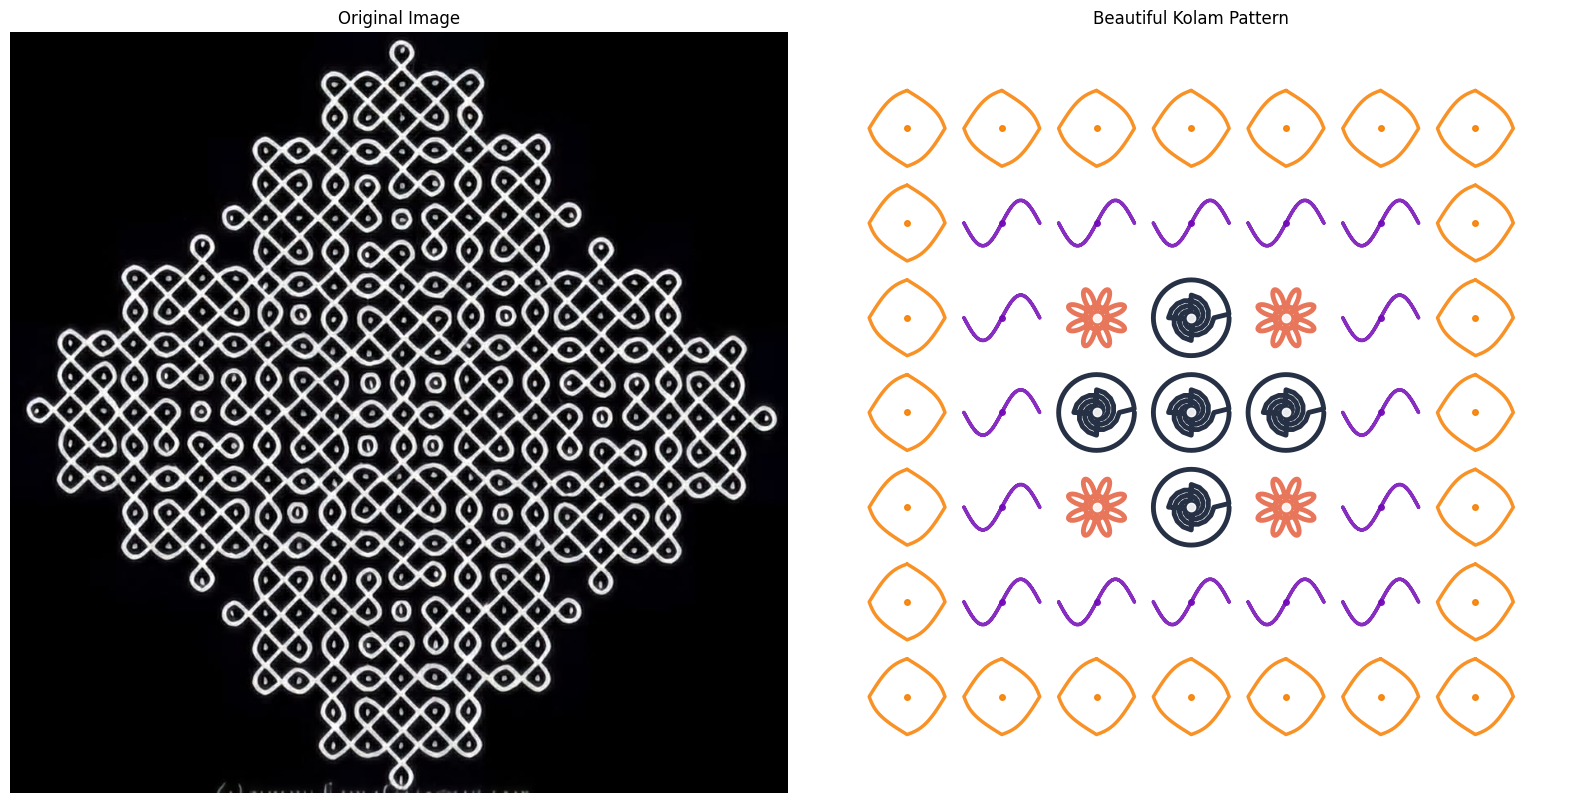


🎉 Beautiful Kolam Generation Complete!
✅ Symmetric 7x7 grid
✅ 4 different pattern types used
✅ Traditional kolam aesthetics applied


In [3]:
#!/usr/bin/env python3
"""
Beautiful Kolam Generator - Creates visually attractive traditional kolam patterns
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import math
from typing import List, Tuple, Dict, Any
import json

class BeautifulKolamGenerator:
    def __init__(self):
        """Initialize with traditional kolam patterns."""
        self.patterns = self._get_traditional_patterns()
        
    def _get_traditional_patterns(self):
        """Traditional kolam patterns with rich curves and symmetry."""
        return {
            # Central mandala pattern - complex and beautiful
            1: {
                "name": "Central Mandala",
                "points": self._generate_mandala_points(),
                "type": "center",
                "symmetry": "4fold"
            },
            # Lotus pattern - elegant curves
            2: {
                "name": "Lotus Pattern", 
                "points": self._generate_lotus_points(),
                "type": "center",
                "symmetry": "8fold"
            },
            # Swirling pattern - dynamic curves
            3: {
                "name": "Swirling Pattern",
                "points": self._generate_swirl_points(),
                "type": "center", 
                "symmetry": "4fold"
            },
            # Corner diamond - traditional
            4: {
                "name": "Corner Diamond",
                "points": self._generate_diamond_points(),
                "type": "corner",
                "symmetry": "4fold"
            },
            # Edge connecting pattern
            5: {
                "name": "Edge Connector",
                "points": self._generate_edge_connector_points(),
                "type": "edge",
                "symmetry": "2fold"
            },
            # Petal pattern - floral
            6: {
                "name": "Petal Pattern",
                "points": self._generate_petal_points(),
                "type": "center",
                "symmetry": "6fold"
            }
        }
    
    def _generate_mandala_points(self) -> List[Tuple[float, float]]:
        """Generate a complex mandala pattern."""
        points = []
        # Outer ring
        for i in range(64):
            angle = 2 * math.pi * i / 64
            r = 0.5
            x = r * math.cos(angle)
            y = r * math.sin(angle)
            points.append((x, y))
        
        # Inner spirals
        for spiral in range(4):
            for i in range(16):
                angle = 2 * math.pi * i / 16 + spiral * math.pi / 2
                r = 0.3 * (1 - i / 16)
                x = r * math.cos(angle)
                y = r * math.sin(angle)
                points.append((x, y))
        
        return points
    
    def _generate_lotus_points(self) -> List[Tuple[float, float]]:
        """Generate a lotus flower pattern."""
        points = []
        # 8 petals
        for petal in range(8):
            angle_offset = petal * math.pi / 4
            for i in range(20):
                t = i / 20
                # Petal shape using parametric equations
                angle = angle_offset + t * math.pi / 4
                r = 0.4 * math.sin(t * math.pi)
                x = r * math.cos(angle)
                y = r * math.sin(angle)
                points.append((x, y))
        
        # Center circle
        for i in range(32):
            angle = 2 * math.pi * i / 32
            r = 0.15
            x = r * math.cos(angle)
            y = r * math.sin(angle)
            points.append((x, y))
        
        return points
    
    def _generate_swirl_points(self) -> List[Tuple[float, float]]:
        """Generate a dynamic swirl pattern."""
        points = []
        # Multiple intertwined spirals
        for spiral in range(3):
            for i in range(50):
                t = i / 50
                angle = 4 * math.pi * t + spiral * 2 * math.pi / 3
                r = 0.5 * t
                x = r * math.cos(angle)
                y = r * math.sin(angle)
                points.append((x, y))
        
        return points
    
    def _generate_diamond_points(self) -> List[Tuple[float, float]]:
        """Generate a traditional diamond pattern."""
        points = []
        # Diamond outline with curves
        diamond_corners = [(0, -0.5), (0.5, 0), (0, 0.5), (-0.5, 0)]
        
        for i, corner in enumerate(diamond_corners):
            next_corner = diamond_corners[(i + 1) % 4]
            # Create curved connection
            for t in range(21):
                t_norm = t / 20
                # Bezier-like curve
                x = corner[0] * (1 - t_norm) + next_corner[0] * t_norm
                y = corner[1] * (1 - t_norm) + next_corner[1] * t_norm
                # Add curve
                curve = 0.1 * math.sin(t_norm * math.pi)
                x += curve * math.cos(i * math.pi / 2)
                y += curve * math.sin(i * math.pi / 2)
                points.append((x, y))
        
        return points
    
    def _generate_edge_connector_points(self) -> List[Tuple[float, float]]:
        """Generate edge connecting patterns."""
        points = []
        # S-curve connector
        for i in range(31):
            t = i / 30
            x = t - 0.5
            y = 0.3 * math.sin(t * 2 * math.pi)
            points.append((x, y))
        
        # Return curve
        for i in range(31):
            t = i / 30
            x = 0.5 - t
            y = 0.3 * math.sin(t * 2 * math.pi + math.pi)
            points.append((x, y))
        
        return points
    
    def _generate_petal_points(self) -> List[Tuple[float, float]]:
        """Generate a petal/flower pattern."""
        points = []
        # 6 petals
        for petal in range(6):
            angle_offset = petal * math.pi / 3
            for i in range(25):
                t = i / 24
                angle = angle_offset + t * math.pi / 6
                r = 0.4 * (1 - 0.3 * t) * math.sin(t * math.pi)
                x = r * math.cos(angle)
                y = r * math.sin(angle)
                points.append((x, y))
        
        return points
    
    def _create_symmetric_grid(self, img_width: int, img_height: int, grid_size: int = 7) -> List[List[Tuple[int, int]]]:
        """Create a symmetric grid for pattern placement."""
        grid = []
        center_x, center_y = img_width // 2, img_height // 2
        spacing = min(img_width, img_height) // (grid_size + 1)
        
        for row in range(grid_size):
            grid_row = []
            for col in range(grid_size):
                x = center_x + (col - grid_size // 2) * spacing
                y = center_y + (row - grid_size // 2) * spacing
                grid_row.append((x, y))
            grid.append(grid_row)
        
        return grid
    
    def _select_pattern_for_position(self, row: int, col: int, grid_size: int) -> int:
        """Select appropriate pattern based on position for symmetry."""
        center = grid_size // 2
        
        # Distance from center
        dist = max(abs(row - center), abs(col - center))
        
        if dist == 0:
            # Center - use most complex pattern
            return 1  # Central Mandala
        elif dist == 1:
            # Inner ring - use medium complexity
            return 2 if (row + col) % 2 == 0 else 3  # Lotus or Swirl
        elif dist == 2:
            # Outer ring - use connecting patterns
            return 5  # Edge Connector
        else:
            # Corners - use diamond
            return 4  # Corner Diamond
    
    def _apply_symmetry(self, pattern_id: int, row: int, col: int, grid_size: int) -> int:
        """Apply 4-fold rotational symmetry."""
        center = grid_size // 2
        rel_row = row - center
        rel_col = col - center
        
        # Map to first quadrant
        abs_row = abs(rel_row)
        abs_col = abs(rel_col)
        
        # Apply symmetry rules
        if pattern_id == 2:  # Lotus
            return 2 if (abs_row + abs_col) % 2 == 0 else 6  # Alternate with petals
        elif pattern_id == 3:  # Swirl
            return 3 if (abs_row + abs_col) % 3 == 0 else 1  # Alternate with mandala
        else:
            return pattern_id
    
    def _transform_pattern(self, pattern: Dict[str, Any], center: Tuple[int, int], scale: float) -> List[Tuple[float, float]]:
        """Transform pattern points to screen coordinates."""
        cx, cy = center
        transformed = []
        
        for point in pattern["points"]:
            x = cx + point[0] * scale
            y = cy + point[1] * scale
            transformed.append((x, y))
        
        return transformed
    
    def _get_pattern_color(self, pattern_id: int, position_type: str) -> str:
        """Get color for pattern based on type and position."""
        colors = {
            "center": "#2E86AB",    # Deep blue
            "edge": "#A23B72",      # Deep pink  
            "corner": "#F18F01",    # Orange
        }
        
        # Alternate colors for variety
        if pattern_id == 1:
            return "#1B263B"  # Dark navy
        elif pattern_id == 2:
            return "#E76F51"  # Coral
        elif pattern_id == 3:
            return "#2A9D8F"  # Teal
        elif pattern_id == 4:
            return "#F77F00"  # Bright orange
        elif pattern_id == 5:
            return "#7209B7"  # Purple
        else:
            return "#06FFA5"  # Mint green
    
    def generate_beautiful_kolam(self, image_path: str, output_path: str = "beautiful_kolam.png"):
        """Generate a visually attractive kolam pattern."""
        print(f"🎨 Generating beautiful kolam from: {image_path}")
        
        # Load image to get dimensions
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Could not load image: {image_path}")
        
        img_height, img_width = img.shape[:2]
        print(f"📐 Image dimensions: {img_width}x{img_height}")
        
        # Create symmetric grid
        grid_size = 7
        grid = self._create_symmetric_grid(img_width, img_height, grid_size)
        print(f"🔢 Created {grid_size}x{grid_size} symmetric grid")
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Left: Original image
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title("Original Image")
        ax1.axis('off')
        
        # Right: Generated kolam
        ax2.set_xlim(0, img_width)
        ax2.set_ylim(img_height, 0)
        ax2.set_aspect('equal')
        ax2.set_facecolor('black')
        ax2.set_title("Beautiful Kolam Pattern")
        
        # Calculate dynamic scale
        spacing = min(img_width, img_height) // (grid_size + 1)
        scale = spacing * 0.8
        
        pattern_usage = {}
        
        # Draw patterns with symmetry and beauty
        for row in range(grid_size):
            for col in range(grid_size):
                center = grid[row][col]
                
                # Select pattern with symmetry
                pattern_id = self._select_pattern_for_position(row, col, grid_size)
                pattern_id = self._apply_symmetry(pattern_id, row, col, grid_size)
                
                pattern = self.patterns[pattern_id]
                pattern_usage[pattern_id] = pattern_usage.get(pattern_id, 0) + 1
                
                # Transform and draw pattern
                transformed_points = self._transform_pattern(pattern, center, scale)
                
                if len(transformed_points) > 1:
                    xs, ys = zip(*transformed_points)
                    color = self._get_pattern_color(pattern_id, pattern["type"])
                    
                    # Draw with varying line widths for depth
                    linewidth = 3.5 if pattern["type"] == "center" else 2.5
                    alpha = 0.95 if pattern["type"] == "center" else 0.85
                    
                    ax2.plot(xs, ys, color=color, linewidth=linewidth, alpha=alpha, solid_capstyle='round')
                    
                    # Add center dot
                    dot_color = 'white' if pattern["type"] == "center" else color
                    dot_size = 6 if pattern["type"] == "center" else 4
                    ax2.plot(center[0], center[1], color=dot_color, marker='o', 
                            markersize=dot_size, alpha=0.9)
        
        ax2.axis('off')
        
        # Print pattern statistics
        print(f"\n✨ Pattern Distribution:")
        for pid, count in sorted(pattern_usage.items()):
            pattern_name = self.patterns[pid]["name"]
            print(f"   {pattern_name}: {count} placements")
        
        # Save and show
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='black')
        print(f"💾 Beautiful kolam saved as: {output_path}")
        plt.show()
        
        return grid, pattern_usage

def main():
    """Generate a beautiful kolam pattern."""
    generator = BeautifulKolamGenerator()
    
    try:
        # Generate beautiful kolam
        grid, usage = generator.generate_beautiful_kolam(
            image_path="D://SIH//Img2.jpg",  # Change to your image path
            output_path="beautiful_kolam.png"
        )
        
        print(f"\n🎉 Beautiful Kolam Generation Complete!")
        print(f"✅ Symmetric {len(grid)}x{len(grid[0])} grid")
        print(f"✅ {len(usage)} different pattern types used")
        print(f"✅ Traditional kolam aesthetics applied")
        
    except Exception as e:
        print(f"❌ Error: {e}")

if __name__ == "__main__":
    main()


In [12]:
import turtle
import math

class KolamGenerator:
    def _init_(self, dot_spacing=30):
        self.dot_spacing = dot_spacing
        self.screen = turtle.Screen()
        self.t = turtle.Turtle()
        self.t.speed(0)
        self.t.penup()
        
        # Symbol to angle mapping (as per Table 1 in the paper)
        self.angle_map = {
            'a': 45,    # 45°
            'b': 135,   # 135°
            'c': -45,   # -45°
            'd': -135   # -135°
        }
        
        # Shape definitions (as per Figures 12-18)
        self.shapes = {
            'I': self.draw_shape_I,
            'II': self.draw_shape_II,
            'III': self.draw_shape_III,
            'IV': self.draw_shape_IV
        }
    
    def set_initial_position(self, grid_type, n):
        """Set the starting position based on grid type (as per Figure 8)"""
        if grid_type == "square":
            # For square Kolams: 270° lattice point of top-left dot
            start_x = -n * self.dot_spacing / 2
            start_y = n * self.dot_spacing / 2
            # Adjust to lattice point (270° direction)
            start_x += self.dot_spacing / 2
            start_y -= self.dot_spacing / 2
        else:  # rhombic
            # For rhombic Kolams: 270° lattice point of left-most dot
            start_x = -n * self.dot_spacing / 2
            start_y = 0
            # Adjust to lattice point (270° direction)
            start_y -= self.dot_spacing / 2
        
        self.t.setposition(start_x, start_y)
        self.t.setheading(135)  # Initial direction (as per paper)
        self.t.pendown()
    
    def draw_dot_grid(self, grid_type, n):
        """Draw the underlying dot grid"""
        self.t.penup()
        
        if grid_type == "square":
            # Draw n x n square grid
            for i in range(n):
                for j in range(n):
                    x = -n * self.dot_spacing / 2 + j * self.dot_spacing
                    y = n * self.dot_spacing / 2 - i * self.dot_spacing
                    self.t.setposition(x, y)
                    self.t.dot(5)
        else:  # rhombic
            # Draw 1-n-1 rhombic grid
            mid = n // 2
            for i in range(n):
                row_dots = 2 * (i if i <= mid else n - i - 1) + 1
                start_x = -row_dots * self.dot_spacing / 2
                y = (mid - i) * self.dot_spacing
                
                for j in range(row_dots):
                    x = start_x + j * self.dot_spacing
                    self.t.setposition(x, y)
                    self.t.dot(5)
        
        self.t.penup()
    
    def preprocess_sequence(self, sequence):
        """Preprocess the sequence as per section 5.2 (Handling initialization issues)"""
        # Add two 'z' at the end for termination (as per section 5.3)
        sequence = sequence + ['z', 'z']
        
        # Check if we need to add symbols at the beginning (shape-IV handling)
        if len(sequence) >= 3 and sequence[-3] == 'd':
            sequence = ['d'] + sequence
        elif len(sequence) >= 3 and sequence[-3] == 'b':
            sequence = ['b'] + sequence
            # Also add 'b' at third position from the end
            if len(sequence) >= 4:
                sequence = sequence[:-3] + ['b'] + sequence[-3:]
        
        return sequence
    
    def draw_shape_I(self, symbol, count=1):
        """Draw Shape I: 0 consecutive changes (straight segments)"""
        angle = self.angle_map[symbol]
        self.t.setheading(angle)
        
        for _ in range(count):
            self.t.forward(self.dot_spacing)
    
    def draw_shape_II(self, e_c, e_1):
        """Draw Shape II: 1 consecutive change"""
        # Implement the 8 possible patterns for Shape II
        patterns = {
            ('b', 'd'): lambda: self._draw_II_bd(),
            ('d', 'c'): lambda: self._draw_II_dc(),
            ('c', 'a'): lambda: self._draw_II_ca(),
            ('a', 'b'): lambda: self._draw_II_ab(),
            ('a', 'c'): lambda: self._draw_II_ac(),
            ('c', 'd'): lambda: self._draw_II_cd(),
            ('d', 'b'): lambda: self._draw_II_db(),
            ('b', 'a'): lambda: self._draw_II_ba()
        }
        
        if (e_c, e_1) in patterns:
            patterns[(e_c, e_1)]()
        else:
            # Default behavior if pattern not recognized
            self.draw_shape_I(e_c)
            self.draw_shape_I(e_1)
    
    def draw_shape_III(self, e_c, e_1, e_2):
        """Draw Shape III: 2 consecutive changes"""
        # Implement the 8 possible patterns for Shape III
        patterns = {
            ('b', 'd', 'c'): lambda: self._draw_III_bdc(),
            ('d', 'c', 'a'): lambda: self._draw_III_dca(),
            ('c', 'a', 'b'): lambda: self._draw_III_cab(),
            ('a', 'b', 'd'): lambda: self._draw_III_abd(),
            ('b', 'a', 'c'): lambda: self._draw_III_bac(),
            ('a', 'c', 'd'): lambda: self._draw_III_acd(),
            ('c', 'd', 'b'): lambda: self._draw_III_cdb(),
            ('d', 'b', 'a'): lambda: self._draw_III_dba()
        }
        
        if (e_c, e_1, e_2) in patterns:
            patterns[(e_c, e_1, e_2)]()
        else:
            # Default behavior if pattern not recognized
            self.draw_shape_I(e_c)
            self.draw_shape_I(e_1)
            self.draw_shape_I(e_2)
    
    def draw_shape_IV(self, e_c, e_1, e_2, e_3):
        """Draw Shape IV: 3 consecutive changes"""
        # Implement the 8 possible patterns for Shape IV
        patterns = {
            ('a', 'b', 'd', 'c'): lambda: self._draw_IV_abdc(),
            ('b', 'd', 'c', 'a'): lambda: self._draw_IV_bdca(),
            ('d', 'c', 'a', 'b'): lambda: self._draw_IV_dcab(),
            ('c', 'a', 'b', 'd'): lambda: self._draw_IV_cabd(),
            ('b', 'a', 'c', 'd'): lambda: self._draw_IV_bacd(),
            ('a', 'c', 'd', 'b'): lambda: self._draw_IV_acdb(),
            ('c', 'd', 'b', 'a'): lambda: self._draw_IV_cdba(),
            ('d', 'b', 'a', 'c'): lambda: self._draw_IV_dbac()
        }
        
        if (e_c, e_1, e_2, e_3) in patterns:
            patterns[(e_c, e_1, e_2, e_3)]()
        else:
            # Default behavior if pattern not recognized
            self.draw_shape_I(e_c)
            self.draw_shape_I(e_1)
            self.draw_shape_I(e_2)
            self.draw_shape_I(e_3)
    
    # Placeholder implementations for specific shape patterns
    def _draw_II_bd(self):
        self.t.setheading(self.angle_map['b'])
        self.t.forward(self.dot_spacing)
        self.t.setheading(self.angle_map['d'])
        self.t.forward(self.dot_spacing)
    
    def _draw_II_dc(self):
        self.t.setheading(self.angle_map['d'])
        self.t.forward(self.dot_spacing)
        self.t.setheading(self.angle_map['c'])
        self.t.forward(self.dot_spacing)
    
    # Add similar implementations for other patterns...
    
    def _draw_III_bdc(self):
        # Implementation for bdc pattern
        pass
    
    def _draw_IV_abdc(self):
        # Implementation for abdc pattern
        pass
    
    # Add implementations for all other patterns...
    
    def simulate_kolam(self, sequence, grid_type, n):
        """Main algorithm for Kolam simulation (as per Algorithm 1)"""
        # Draw the dot grid
        self.draw_dot_grid(grid_type, n)
        
        # Set initial position
        self.set_initial_position(grid_type, n)
        
        # Preprocess the sequence
        sequence = self.preprocess_sequence(sequence)
        
        i = 0
        while i < len(sequence) - 3:
            e_c, e_1, e_2, e_3 = sequence[i], sequence[i+1], sequence[i+2], sequence[i+3]
            
            # Check for Shape IV condition
            if (e_3 != 'z' and e_c != e_1 and e_1 != e_2 and e_2 != e_3):
                self.draw_shape_IV(e_c, e_1, e_2, e_3)
                i += 3
            
            # Check for Shape III condition
            elif (e_2 != 'z' and e_c != e_1 and e_1 != e_2):
                self.draw_shape_III(e_c, e_1, e_2)
                i += 2
            
            # Check for Shape II condition
            elif e_c != e_1:
                self.draw_shape_II(e_c, e_1)
                i += 1
            
            # Otherwise, it's Shape I
            else:
                # Count consecutive same symbols
                j = 0
                while i+j < len(sequence)-1 and sequence[i+j] == sequence[i+j+1]:
                    j += 1
                
                # Draw Shape I for the consecutive symbols
                if j > 0:
                    self.draw_shape_I(e_c, j)
                    i += j
                else:
                    i += 1
        
        # Finish drawing
        self.t.penup()
    
    def generate_navagraha_kolam(self, kolam_number):
        """Generate one of the 9 Navagraha Kolams (3x3 square) from Table 2"""
        navagraha_sequences = [
            # Kolam 1
            ['b', 'a', 'c', 'c', 'c', 'd', 'd', 'c', 'a', 'b', 'b', 'a', 'a', 'a', 'c', 'd', 'd', 'c', 'c', 'd', 'b', 'a', 'a', 'b', 'b', 'b', 'd', 'd', 'd', 'c', 'c', 'd', 'b', 'a', 'a', 'b'],
            # Kolam 2
            ['b', 'a', 'c', 'c', 'c', 'c', 'c', 'd', 'b', 'a', 'a', 'b', 'd', 'd', 'd', 'c', 'a', 'b', 'b', 'b', 'd', 'c', 'c', 'd', 'b', 'a', 'a', 'a', 'a', 'a', 'c', 'd', 'b', 'b', 'd', 'd'],
            # Add sequences for Kolams 3-9...
        ]
        
        if 1 <= kolam_number <= len(navagraha_sequences):
            self.simulate_kolam(navagraha_sequences[kolam_number-1], "square", 3)
    
    def generate_rhombic_kolam(self, n):
        """Generate rhombic Kolam (1-n-1) from Table 3"""
        if n == 3:
            sequence = ['b', 'a', 'c', 'c', 'c', 'd', 'b', 'a', 'a', 'a', 'c', 'd', 'b', 'b', 'b', 'a', 'c', 'd', 'd', 'd']
        elif n == 5:
            sequence = ['b', 'a', 'c', 'c', 'c', 'd', 'b', 'a', 'a', 'a', 'a', 'a', 'c', 'd', 'b', 'b', 'b', 'a', 'c', 'd', 'd', 'd', 'b', 'a', 'c', 'c', 'c', 'd', 'd', 'c', 'c', 'd', 'b', 'a', 'a', 'a', 'a', 'a', 'c', 'd', 'b', 'b', 'd', 'c', 'c', 'd', 'b', 'b', 'b', 'b', 'd', 'd']
        elif n == 7:
            sequence = ['b', 'a', 'c', 'c', 'c', 'c', 'a', 'b', 'b', 'b', 'b', 'a', 'c', 'c', 'c', 'c', 'c', 'd', 'd', 'd', 'b', 'a', 'c', 'c', 'c', 'd', 'b', 'a', 'a', 'a', 'c', 'd', 'b', 'b', 'b', 'a', 'a', 'a', 'a', 'a', 'c', 'd', 'd', 'd', 'd', 'c', 'a', 'a', 'a', 'a', 'c', 'd', 'b', 'b', 'b', 'b', 'd', 'c', 'c', 'c', 'c', 'd', 'b', 'b', 'b', 'b', 'b', 'a', 'a', 'a', 'c', 'd', 'b', 'b', 'b', 'a', 'c', 'd', 'd', 'd', 'b', 'a', 'c', 'c', 'c', 'd', 'd', 'd', 'd', 'd', 'b', 'a', 'a', 'a', 'a', 'b', 'd', 'd', 'd', 'd']
        else:
            raise ValueError("Only n=3,5,7 are supported for rhombic Kolams")
        
        self.simulate_kolam(sequence, "rhombic", n)
    
    # def close(self):
    #     """Close the turtle graphics window"""
    #     self.screen.exitonclick()

# Example usage
if __name__ == "__main__":
    generator = KolamGenerator()
    
    # Generate a Navagraha Kolam (3x3 square)
    generator.generate_navagraha_kolam(30)
    
    # Generate a rhombic Kolam (1-3-1)
    # generator.generate_rhombic_kolam(3)
    
    # generator.close()